In [129]:
import numpy as np 
import pandas as pd 
import os 
import h5py 
import csv 
import datetime as dt
import matplotlib.pyplot as plt

In [130]:
file_loc = 'iel.hdf5'

<h2><font color = #bf5700>Conversion to pd Data Frame</font></h2>

The data is stored in a dataframe like object with each column (datetime, usage) stored in byte - strings with utf8 encoding. We need to convert data columns from byte-string to datetime and float

In [169]:
# Convert byte dataframe to one of Datetime + float
def byte_to_obj(build_df):
    df = build_df.copy()
    #Byte to String (decode utf8) to Datetime (parsetime with format YYYY-mm-dd HH:MM:SS)
    df.loc[:,0] = df.apply(lambda x:dt.datetime.strptime(x[0].decode('utf8'),'%Y-%m-%d %H:%M:%S'),axis=1 )
    #Byte to String (decode utf8) to float
    df.loc[:,1] = df.apply(lambda x: float(x[1].decode('utf8')),axis=1)
    return df
#Clean zero values
def clean_zero(build_df):
    df = build_df.copy()
    #Return times and data where usage is positive.
    #Filters zero and negative numbers
    return df[df[1]>0]
#Rencode from Datetime + float to byte:
def reencode(build_df):
    df = build_df.copy()
    df = df.loc[:,(0,1)]
    #Byte to String (decode utf8) to Datetime (parsetime with format YYYY-mm-dd HH:MM:SS)
    df.loc[:,0] = df.apply(lambda x:dt.datetime.strftime(x[0],'%Y-%m-%d %H:%M:%S').encode('utf8'),axis=1 )
    #Byte to String (decode utf8) to float
    df.loc[:,1] = df.apply(lambda x: str(x[1]).encode('utf8'),axis=1)
    return df

A way to visualize yearly data:

In [132]:
def plot_hourly(build_df,year,style='-',title='',xlabel = '', ylabel = ''):
    df = build_df.copy()
    df.loc[:,0] = df.apply(lambda x: (x[0]-dt.datetime(year=year,month=1,day=1)).total_seconds()/3600,axis=1)
    plt.plot(df.loc[:,0],df.loc[:,1],style)
    if ylabel == '':
        ylabel = 'Energy Usage (kWH)'
    plt.ylabel(ylabel)
    if xlabel == '':
        xlabel = 'Hours after Jan 1, {} 0:00'.format(year)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

<h2><font color = #bf5700> Outlier Visualization </font></h2>

Even with the data converted and cleaned, data has extreme outliers, as can be seen below

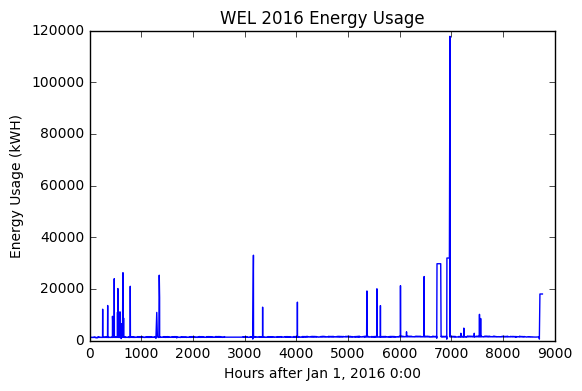

In [133]:
with h5py.File(file_loc,'r') as f: 
    df = pd.DataFrame(f['utexas/WEL/2016'][()])
    cleaned = clean_zero(byte_to_obj(df))
    plot_hourly(cleaned,2016,title='WEL 2016 Energy Usage')
    

<h2><font color = #bf5700> Log Scale Visualization  </font> </h2>

Standard outlier detection won't work for several reasons, the main being that the outliers can reach averages as high as 3 million, which significantly skews summary statistics like mean and standard deviation.

A dataset with a lot of these outliers for example, will cause standard mu/sigma or iqr pruning to miss smaller outliers. A log conversion and then a standard pruning was found to work best. 

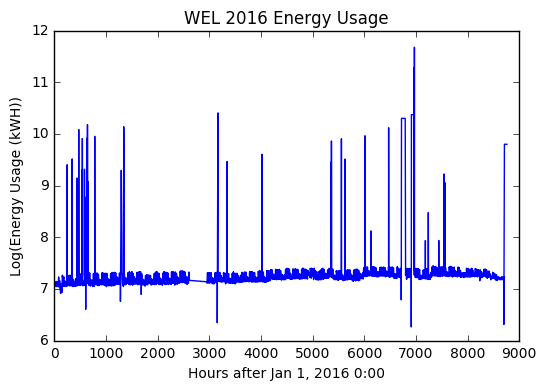

In [134]:
with h5py.File(file_loc,'r') as f: 
    df = pd.DataFrame(f['utexas/WEL/2016'][()])
    cleaned = clean_zero(byte_to_obj(df))
    cleaned.loc[:,1] = cleaned.apply(lambda x: np.log(x[1]),axis = 1)
    plot_hourly(cleaned,2016,title='WEL 2016 Energy Usage',ylabel ='Log(Energy Usage (kWH))')

<h2><font color = #bf5700>Log-based mean/sd outlier removal</font></h2>

This function, removes outliers that are within a certain spread. I.e it removes rows whose value at a certain axis (axis) is outside the range of $$(\mu - z\sigma, \mu + z\sigma)$$
where $z$ is our spread

In [135]:
def musigma_prune (build_df,axis, spread = 2):
    df = build_df.copy()
    mu = np.mean(df.loc[:,axis])
    sigma = np.std(df.loc[:,axis])
    ub = mu + spread*sigma
    lb = mu - spread*sigma
    return df[(df[axis]<ub) & (df[axis]>lb)]

In [136]:
def iqr_prune(build_df,axis,spread = 1.5):
    df = build_df.copy()
    q1,q3 = np.percentile(df.loc[:,axis],[25,75])
    ub = q3+spread*(q3-q1)
    lb = q1-spread*(q3-q1)
    return df[(df[axis]<ub) & (df[axis]>lb)]
    
    

<h2><font color = #bf5700>Derivative-based outlier removal</font></h2>

But soon we will see that this pruning, while effective, is not enough. The reason, is that we are dealing with <b> Time series </b> data. Run the code and look at the plot below. This is the plot of a dormitory building during Jan 2014 - Dec 2014. There are clear drops in the data during winter break, spring break, Thanksgiving break, and the biggest one, summer vacation. 

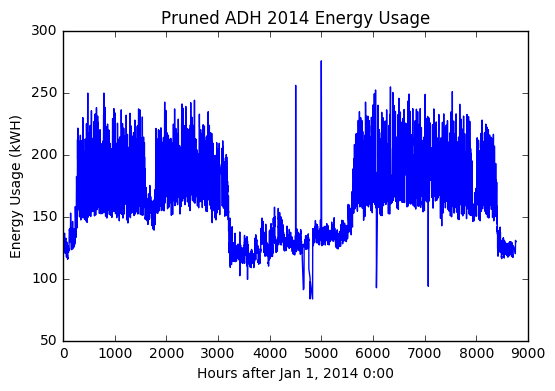

In [137]:
with h5py.File(file_loc,'r') as f: 
    df = pd.DataFrame(f['utexas/ADH/2014'][()])
    cleaned = clean_zero(byte_to_obj(df))
    cleaned.loc[:,1] = cleaned.apply(lambda x: np.log(x[1]),axis = 1)
    pruned = iqr_prune(cleaned,1,spread = 1.5)
    pruned.loc[:,1] = pruned.apply(lambda x: np.exp(x[1]),axis = 1)
    plot_hourly(pruned,2014,title='Pruned ADH 2014 Energy Usage',ylabel ='Energy Usage (kWH)')
    

However, there is a clear outlier in the middle of the winter break period. However, summary statistics <b>cannot</b> detect this as an outlier. The reason is that the value (~240) is <b><i> not </i></b> anomalous for the entire data; it is in line with school-time energy usage. But it is anomalous given its surroundings. So we need to calculate the derivative to remove any outliers

In [138]:
#Adds a derivative column to a df
def gen_deriv(build_df,axis):
    df = build_df.copy()
    df.sort_values(by=0,inplace=True)
    derivatives = [0]
    temp = np.nan 
    i = 0 
    for m in df.loc[:,axis]:
        i = i+1
        if temp is np.nan:
            temp = m
        else:
            derivatives.append(m-temp)
            temp = m
    df.loc[:,'D'] = derivatives
    return df

In [139]:
with h5py.File(file_loc,'r') as f: 
    df = pd.DataFrame(f['utexas/ADH/2014'][()])
    cleaned = clean_zero(byte_to_obj(df))
    cleaned.loc[:,1] = cleaned.apply(lambda x: np.log(x[1]),axis = 1)
    pruned = iqr_prune(cleaned,1,spread = 2)
    print(gen_deriv(pruned,1).head())
    

                    0         1         D
0 2014-01-01 00:00:00  4.892227  0.000000
1 2014-01-01 01:00:00  4.892227  0.000000
2 2014-01-01 02:00:00  4.903421  0.011194
3 2014-01-01 03:00:00  4.901564 -0.001857
4 2014-01-01 04:00:00  4.894101 -0.007463


Then a second round of outlier removal can commence, and the results are visibly better

0.07397483690587137


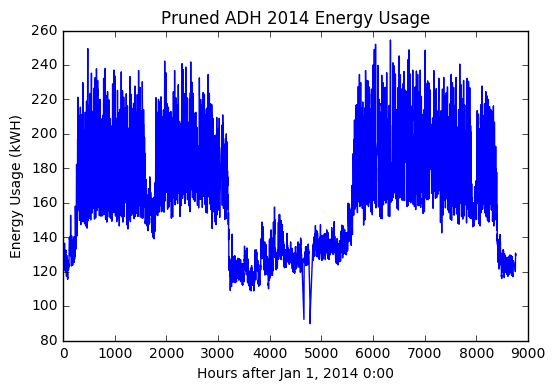

In [140]:
with h5py.File(file_loc,'r') as f: 
    df = pd.DataFrame(f['utexas/ADH/2014'][()])
    cleaned = clean_zero(byte_to_obj(df))
    cleaned.loc[:,1] = cleaned.apply(lambda x: np.log(x[1]),axis = 1)
    pruned = iqr_prune(cleaned,1,spread = 1.5)
    pruned = gen_deriv(pruned,1)
    pruned = iqr_prune(pruned,'D',spread = 1.5)
    print(1-len(pruned)/len(cleaned))
    pruned.loc[:,1] = pruned.apply(lambda x: np.exp(x[1]),axis = 1)
    plot_hourly(pruned,2014,title='Pruned ADH 2014 Energy Usage',ylabel ='Energy Usage (kWH)')
    

<h2><font color = #bf5700>Single preprocessing method</font></h2>
We can summarize all the outlier removal steps into one method, below. 

In [267]:
def outlier_prune(build_df,method='p'):
    raw = build_df.copy()
    in_len = len(raw)
    if(in_len ==0):
        if(method == 'p'):
            print('Empty dataset')
            return 0
        else:
            return (0,0)
    df = clean_zero(byte_to_obj(raw))
    if(len(df) ==0):
        if(method == 'p'):
            print('Empty dataset')
            return 0
        else:
            return (0,0)
    df.loc[:,1] = df.apply(lambda x: np.log(x[1]),axis =1) 
    df = gen_deriv(df,axis = 1)
    df = iqr_prune(df,axis=1,spread=1.5)
    if(len(df)==0):
        if(method == 'p'):
            print('Empty dataset')
            return 0
        else:
            return (0,0)
    df = iqr_prune(df,axis='D',spread=1.5)
    if(len(df)==0):
        if(method == 'p'):
            print('Empty dataset')
            return 0
        else:
            return (0,0)
    df.loc[:,1] = df.apply(lambda x: np.exp(x[1]),axis=1)
    if(method =='p' or method =='P'):
        print('{}% of outliers pruned'.format((1-len(df)/in_len)*100))
        return df
    else: 
        return (df,(1-len(df)/in_len)*100)
def plot_utexas(building,year,style='-'):
    with h5py.File(file_loc,'r') as f: 
        try:
            data= pd.DataFrame(f['utexas/{}/{}'.format(building,year)][()])
            cleaned = clean_zero(byte_to_obj(data))
            plot_hourly(outlier_prune(cleaned),year,style)
        except:
            print('{} data for building {} not found'.format(year,building))

In [177]:
import matplotlib.pyplot as plt
def daily_profile(dset,building, year, prune = True):
    with h5py.File(file_loc,'r') as f:
        df = pd.DataFrame(f['{}/{}/{}'.format(dset,building,year)][()])
        if prune:
            df = outlier_prune(df)
        else:
            df = clean_zero(byte_to_obj(df))
        hour_avs= []
        for h in range(24):
            hour_data = df[df.apply(lambda x: x[0].hour==h,axis=1)][1]
            hour_avs.append(sum(hour_data)/len(hour_data))
        return hour_avs


In [178]:
def yearly_profile(building,year, prune = True):
    with h5py.File(file_loc,'r') as f:
        df = pd.DataFrame(f['utexas/{}/{}'.format(building,year)][()])
        if prune:
            df = outlier_prune(df)
        else:
            df = clean_zero(byte_to_obj(df))
        hour_avs= []
        for h in range(24):
            hour_data = df[df.apply(lambda x: x[0].hour==h,axis=1)][1]
            hour_avs.append(sum(hour_data)/len(hour_data))
        return hour_avs


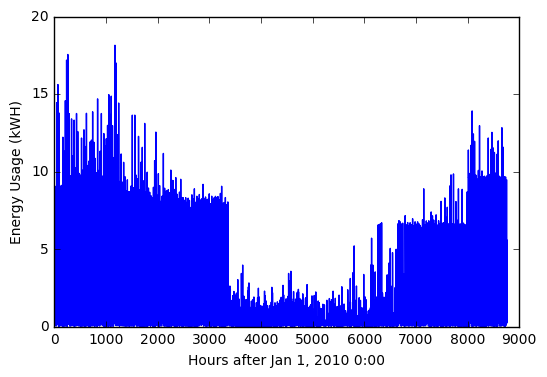

In [144]:
with h5py.File(file_loc,'r') as f:
    df = pd.DataFrame(f['ireland/1049/2010'][()])
    df = clean_zero(byte_to_obj(df))
    plot_hourly(df,2010)

5.503539620918019% of outliers pruned


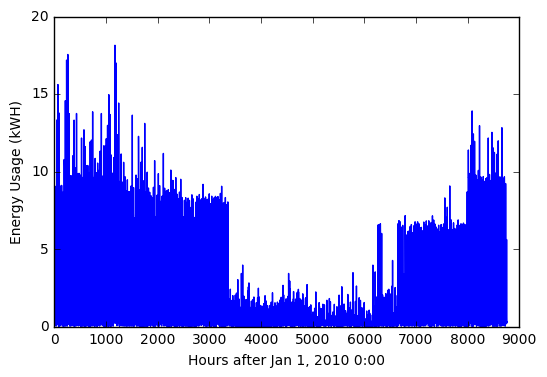

In [147]:
with h5py.File(file_loc,'r') as f:
    df = pd.DataFrame(f['ireland/1049/2010'][()])
    df =outlier_prune(df)
    plot_hourly(df,2010)

In [148]:
with h5py.File(file_loc,'r') as f:
    #print([l for l in f['MIT/M2A/2015'].keys()])
    df = pd.DataFrame(f['MIT/M2A/2015'][()])
    outlier_prune(df)

2.987777274784975% of outliers pruned


In [149]:
ireland_1049 = daily_profile('utexas','ADH',2015, prune = True)
ireland_10492 = daily_profile('utexas','ADH',2016, prune = True)

3.2974661575841724% of outliers pruned
4.585987261146496% of outliers pruned


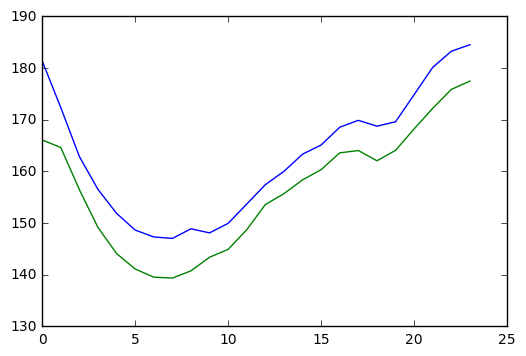

In [150]:
plt.plot(np.arange(24),np.hstack((np.array(ireland_1049).reshape((-1,1)),np.array(ireland_10492).reshape((-1,1)))))
plt.show()

In [220]:
def clean_and_copy(dset):
    with h5py.File('iel.hdf5') as f:
        if(dset not in f):
            print('Dataset not found')
        else:
            with h5py.File('cleaned.hdf5') as cl:
                if dset not in cl: 
                    cl_dset = cl.create_group(dset)
                    num = len(f[dset].keys())
                    i=0
                    for building in f[dset].keys():
                        i = i+1
                        print('Now Copying Building #{}/{}.........{}'.format(i,num,building))
                        b = f['{}/{}'.format(dset,building)]
                        cl_b = cl_dset.create_group(building)
                        for year in b.keys():
                            print('..........Year:{}'.format(year))
                            df = pd.DataFrame(b[year][()])
                            vals = outlier_prune(df, method='r')
                            if(vals[0] is 0):
                                print('Empty dataset found')
                            else:
                                cl_b[year] = reencode(vals[0]).as_matrix().astype(np.string_)
                                cl_b[year].attrs['outlier'] = vals[1]
                                b[year].attrs['outlier']=vals[1]
                                for m in b.attrs:
                                    cl_b.attrs[m]=b.attrs[m]
                                
            
      

In [199]:
clean_and_copy('utexas')

Now Copying Building #1/112.........ADH
..........Year:2009
..........Year:2010
..........Year:2011
..........Year:2012
..........Year:2013
..........Year:2014
..........Year:2015
..........Year:2016
..........Year:2017
Now Copying Building #2/112.........AHG
..........Year:2010
..........Year:2011
..........Year:2012
..........Year:2013
..........Year:2014
..........Year:2015
..........Year:2016
..........Year:2017
Now Copying Building #3/112.........ANB
..........Year:2014
..........Year:2015
..........Year:2016
..........Year:2017
Now Copying Building #4/112.........AND
..........Year:2010
..........Year:2011
..........Year:2012
..........Year:2013
..........Year:2014
..........Year:2015
..........Year:2016
..........Year:2017
Now Copying Building #5/112.........ARC
..........Year:2009
..........Year:2010
..........Year:2011
..........Year:2012
..........Year:2013
..........Year:2014
..........Year:2015
..........Year:2016
..........Year:2017
Now Copying Building #6/112.........ART


In [271]:
clean_and_copy('pecan')

Now Copying Building #1/747.........101
..........Year:2014
..........Year:2015
..........Year:2016
..........Year:2017
Now Copying Building #2/747.........1037
..........Year:2014
..........Year:2015
Now Copying Building #3/747.........1069
..........Year:2013
..........Year:2014
..........Year:2015
Now Copying Building #4/747.........1086
..........Year:2013
..........Year:2014
..........Year:2015
..........Year:2016
..........Year:2017
Now Copying Building #5/747.........1103
..........Year:2012
..........Year:2013
..........Year:2014
..........Year:2015
..........Year:2016
..........Year:2017
Now Copying Building #6/747.........1105
..........Year:2013
..........Year:2014
..........Year:2015
Now Copying Building #7/747.........114
..........Year:2013
..........Year:2014
..........Year:2015
..........Year:2016
..........Year:2017
Now Copying Building #8/747.........115
..........Year:2014
..........Year:2015
..........Year:2016
..........Year:2017
Now Copying Building #9/747........

In [280]:
clean_and_copy('genome')

Now Copying Building #1/507.........Office_Abbey
..........Year:2015
Now Copying Building #2/507.........Office_Abigail
..........Year:2015
Now Copying Building #3/507.........Office_Al
..........Year:2015
Now Copying Building #4/507.........Office_Alannah
..........Year:2015
Now Copying Building #5/507.........Office_Aliyah
..........Year:2015
Now Copying Building #6/507.........Office_Allyson
..........Year:2015
Now Copying Building #7/507.........Office_Alyson
..........Year:2015
Now Copying Building #8/507.........Office_Amelia
..........Year:2015
Now Copying Building #9/507.........Office_Amelie
..........Year:2015
Now Copying Building #10/507.........Office_Anastasia
..........Year:2015
Now Copying Building #11/507.........Office_Andrea
..........Year:2015
Now Copying Building #12/507.........Office_Angelica
..........Year:2015
Now Copying Building #13/507.........Office_Angelina
..........Year:2015
Now Copying Building #14/507.........Office_Angelo
..........Year:2015
Now Copyin

In [282]:
clean_and_copy('ireland')

Now Copying Building #1/6435.........1000
..........Year:2009
..........Year:2010
Now Copying Building #2/6435.........1001
..........Year:2009
..........Year:2010
Now Copying Building #3/6435.........1002
..........Year:2009
..........Year:2010
Now Copying Building #4/6435.........1003
..........Year:2009
..........Year:2010
Now Copying Building #5/6435.........1004
..........Year:2009
..........Year:2010
Now Copying Building #6/6435.........1005
..........Year:2009
..........Year:2010
Now Copying Building #7/6435.........1006
..........Year:2009
..........Year:2010
Now Copying Building #8/6435.........1007
..........Year:2009
..........Year:2010
Now Copying Building #9/6435.........1008
..........Year:2009
..........Year:2010
Now Copying Building #10/6435.........1009
..........Year:2009
..........Year:2010
Now Copying Building #11/6435.........1010
..........Year:2009
..........Year:2010
Now Copying Building #12/6435.........1011
..........Year:2009
..........Year:2010
Now Copying B

In [287]:
clean_and_copy('MIT')

Now Copying Building #1/87.........E15A
..........Year:2014
..........Year:2015
..........Year:2016
Now Copying Building #2/87.........E15B
..........Year:2014
..........Year:2015
..........Year:2016
Now Copying Building #3/87.........E18A
..........Year:2014
..........Year:2015
..........Year:2016
Now Copying Building #4/87.........E18B
..........Year:2014
..........Year:2015
..........Year:2016
Now Copying Building #5/87.........E18C
..........Year:2014
Empty dataset found
..........Year:2015
Empty dataset found
..........Year:2016
Now Copying Building #6/87.........E19A
..........Year:2014
..........Year:2015
..........Year:2016
Now Copying Building #7/87.........E19B
..........Year:2014
..........Year:2015
..........Year:2016
Now Copying Building #8/87.........E1A
..........Year:2014
..........Year:2015
..........Year:2016
Now Copying Building #9/87.........E23A
..........Year:2014
..........Year:2015
..........Year:2016
Now Copying Building #10/87.........E23B
..........Year:2014


In [291]:
with h5py.File('iel.hdf5','r') as f:
    hours = 0 
    count = 0 
    for m in f.keys():
        dset = f[m]
        for buil in dset.keys():
            building = dset[buil]
            for y in building.keys():
                df = pd.DataFrame(building[y][()])
                hours = hours+len(df)
                count = count + 1
    print('{} Datasets and {} Total Hours'.format(count,hours))

17072 Datasets and 106941395 Total Hours


In [292]:
with h5py.File('cleaned.hdf5','r') as f:
    hours = 0 
    count = 0 
    for m in f.keys():
        dset = f[m]
        for buil in dset.keys():
            building = dset[buil]
            for y in building.keys():
                df = pd.DataFrame(building[y][()])
                hours = hours+len(df)
                count = count + 1
    print('{} Datasets and {} Total Hours'.format(count,hours))

16907 Datasets and 94118408 Total Hours


In [227]:
with h5py.File(file_loc,'r') as f:
    dfv = pd.DataFrame(f['pecan/7800/2017'][()])
    

In [251]:
sd = clean_zero(byte_to_obj(dfv))
sd[1] = sd.apply(lambda x: np.log(x[1]),axis=1)

In [266]:
sdd = gen_deriv(sd,axis=1)
np.percentile(sdd[1].tolist(),[25,75])

array([ 0.2934156,  0.2934156])

In [172]:
[f for f in sd.loc[:,1] if f<=0]

[]

In [159]:
sd.loc[:,1] = sd.apply(lambda x: np.log(x[1]),axis =1) 

In [173]:
np.percentile(sd.loc[:,1],[25,75])

array([ 110.3196,  196.    ])

In [286]:
with h5py.File('iel.hdf5') as cl:
    print([l for l in cl.keys()])

['MIT', 'genome', 'ireland', 'pecan', 'utexas']


In [285]:
with h5py.File('cleaned.hdf5') as cl:
    print([l for l in cl.keys()])

['genome', 'ireland', 'pecan', 'utexas']
